# Solving Recurrences with Generating Functions

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sympy as sp

from functools import lru_cache
from matplotlib import rc

rc('text',  usetex=True)
sp.init_printing()

In [2]:
%%latex

Consider the mutually recursive sequences:
    
\begin{align}
    a_n &= \sum_{k=1}^{n-1}(1-p)^{k-1}p(1+b_{n-k}) \\
    b_n &= \sum_{k=2}^{n-1}(1-p)^{k-2}p(1+a_{n-k})
\end{align}

where $a_0 = b_0 = 0$.

<IPython.core.display.Latex object>

In [3]:
@lru_cache(maxsize=None) 
def fa(n, p): 
    if n == 0: return 0 
    return sum((1-p)**(k-1)*p*(1+fb(n-k, p)) for k in range(1,n)) 

@lru_cache(maxsize=None) 
def fb(n, p): 
    if n == 0: return 0 
    return sum((1-p)**(k-2)*p*(1+fa(n-k, p)) for k in range(2,n))

In [4]:
fa(9, .5)

In [5]:
%%latex
We consider the generating functions:

\begin{align}
G_a(z) &= \sum_{n\geq 0} a_nz^n \\
       &= \sum_{n \geq 1}\left(\sum_{k=1}^{n-1}(1-p)^{k-1}p(1+b_{n-k})\right)z^n  \\
       &= \sum_{n \geq 2}\left(\sum_{k=1}^{n-1}(1-p)^{k-1}p\right)z^n + \sum_{k\geq 1}\left(\sum_{n > k}(1-p)^{k-1}pb_{n-k}\right)z^n \\
       &= \sum_{n \geq 2}\left(\sum_{k=1}^{n-1}(1-p)^{k-1}p\right)z^n + G_b(z)\sum_{k\geq 1}(1-p)^{k-1}pz^k \\
\end{align}
and
\begin{align}
G_b(z) &= \sum_{n\geq 0} b_nz^n \\
       &= \sum_{n \geq 1}\left(\sum_{k=2}^{n-1}(1-p)^{k-1}p(1+a_{n-k})\right)z^n  \\
       &= \sum_{n \geq 3}\left(\sum_{k=2}^{n-1}(1-p)^{k-1}p\right)z^n + \sum_{k\geq 2}\left(\sum_{n > k}(1-p)^{k-1}pa_{n-k}\right)z^n \\
       &= \sum_{n \geq 3}\left(\sum_{k=2}^{n-1}(1-p)^{k-1}p\right)z^n + G_a(z)\sum_{k\geq 2}(1-p)^{k-1}pz^k \\
\end{align}

After some simplifications via the geometric sum formula, we get a system of linear equations in $G_a(z)$ and $G_b(z)$.

<IPython.core.display.Latex object>

In [6]:
a, b = sp.symbols('G_a, G_b')
z = sp.symbols('z', positive=True)
k, j, n = sp.symbols('k, j, n', nonnegative=True)
p = sp.symbols('p', positive=True)

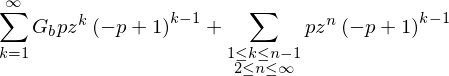

In [7]:
ans1 = sp.Sum(sp.Sum((1-p)**(k-1)*p*z**n, (k,1,n-1)), (n,2,sp.oo)) + sp.Sum((1-p)**(k-1)*p*z**k*b, (k,1,sp.oo))
ans1

In [8]:
r1 = ans1.doit().subs(z < 1, True).subs(z*sp.Abs(p-1) < 1, True)
eq1 = sp.Eq(a, r1)

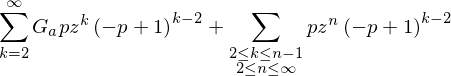

In [9]:
ans2 = sp.Sum(sp.Sum((1-p)**(k-2)*p*z**n, (k,2,n-1)), (n,2,sp.oo)) + sp.Sum((1-p)**(k-2)*p*z**k*a, (k,2,sp.oo))
ans2

In [10]:
r2 = ans2.doit().subs(z < 1, True).subs(z*sp.Abs(p-1) < 1, True)
eq2 = sp.Eq(b, r2)

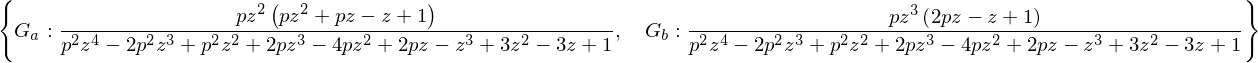

In [11]:
ans = sp.solve((eq1, eq2), (a, b))
ans

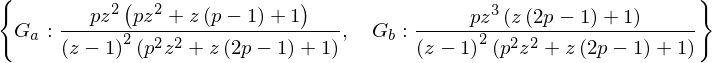

In [12]:
Ga = sp.factor(ans[a], z)
Gb = sp.factor(ans[b], z)
{a: Ga, b: Gb}

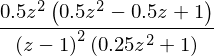

In [13]:
Ga.subs(p,.5)

In [14]:
sp.series(Ga.subs(p,.5), z, n=21)

In [15]:
[fa(x, .5) for x in range(21)]

In [16]:
sp.series(Ga, z, n=10)

In [17]:
%%latex
Notice that $[z^n]G_a(z) = a_n$, as desired.

<IPython.core.display.Latex object>

In [18]:
(z*sp.simplify(sp.diff(Ga, z))/Ga).subs(z, 1)

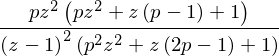

In [19]:
Ga

In [20]:
f = lambda z: sp.ln(Ra) - (n+1)*sp.ln(z)

In [21]:
from scipy.optimize import curve_fit
E = 1000
N = 200
X = range(N)

In [22]:
# Looks like a(x-1)
for pr in np.linspace(0+1/E,1-1/E,E):
    ps, err, *_ = np.polyfit(x=X, y=[fa(x, pr) for x in X], deg=1, full=True)
    # print(ps, err)

In [23]:
# Ansatz: [z^n]G(z) ~ az + b

data = [
    (pr, np.polyfit(x=X, y=[fa(x, pr) for x in X], deg=1)[0])
    for pr in np.linspace(0+1/E,1-1/E,E)
]

xs, ys = [np.array(z, dtype=np.float64) for z in zip(*data)]

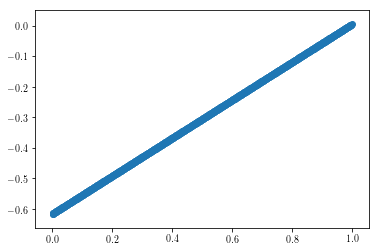

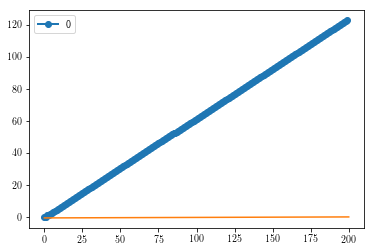

In [24]:
yss = [fa(x, .9) for x in X]
ps = np.polyfit(x=X, y=yss, deg=1)
plt.scatter(xs, np.polyval(ps, xs))
pd.DataFrame(yss).plot(lw=2, marker='o')
xss = np.linspace(0, N, E)
plt.plot(xss, np.polyval(ps, xs))

[ 0.37026975 -1.64576683  0.99634195  0.92455208]
[[ 9.35702704e-08  4.87583428e-07  2.26361581e-07 -2.53664659e-07]
 [ 4.87583428e-07  2.61001890e-06  1.26578533e-06 -1.39315741e-06]
 [ 2.26361581e-07  1.26578533e-06  6.55638017e-07 -7.02659626e-07]
 [-2.53664659e-07 -1.39315741e-06 -7.02659626e-07  7.61204247e-07]]


Text(0.5,1,'$P_H$ vs. Slope of growth fn')

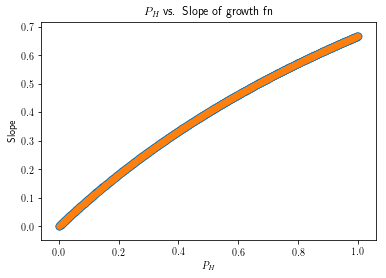

In [25]:
# This is a guess.
def g(x, a, b, c, d):
    return a*np.sinh(b+c*x) + d


popt, pcov = curve_fit(g, xs, ys)
print(popt)
print(pcov)
plt.scatter(xs, ys, lw=2)
plt.scatter(xs, g(xs, *popt), lw=.02)
plt.xlabel('$P_H$')
plt.ylabel('Slope')
plt.title('$P_H$ vs. Slope of growth fn')


# There are two plots on top of each other: orange is on top of blue.




In [26]:
%%latex
This seems to say that the expected number of connections for a polypeptide with $P_H = p$ and of length $2n$ 
is around


\begin{align} \left(0.37026975\sinh\left(0.99634195p-1.64576683\right)+0.92455208\right)(n-1),\end{align}

with the greedy algorithm. Note that this assumes that the polypeptide has a leading $\texttt H$ amino acid.

<IPython.core.display.Latex object>

In [27]:
%%latex
In contrast, the algorithm which just folds a length $2n$ polypeptide in half has an expected number of
connections of about $np^2$.

<IPython.core.display.Latex object>

In [28]:
from sympy.functions.elementary.hyperbolic import sinh
ITER = 100

def gs(p, a, b, c, d):
    return a*sinh(b+c*p) + d

f1 = gs(p, *popt)*(n-1)
f2 = (n-1)*p**2

pl = 0.
ph = 1.

# Use bisection method to find when f1 dominates f2 or vice-versa.
for _ in range(ITER):
    pm = (pl+ph)/2.
    
    # Plug in probability.
    f1v = f1.subs(p,pm)
    f2v = f2.subs(p,pm)
    
    # Find intersection point(s).
    ix = sp.solve(sp.Eq(f1v, f2v), n)
    
    # Compare slopes.
    s1 = sp.diff(f1v, n).subs(n, ix)
    s2 = sp.diff(f2v, n).subs(n, ix)
    if s1 > s2:
        pl = pm
    else:
        ph = pm

print(f'When p > {pm}, folding in half is yields more connections in expectation than the greedy algorithm.')

When p > 0.7318517225918733, folding in half is yields more connections in expectation than the greedy algorithm.
